In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Train the Model First
df = pd.read_csv("fake_real_news.csv") # Loading the Dataset 
df["date"] = pd.to_datetime(df["date"])
df["content"] = df["title"] + " " + df["text"]

In [2]:
# TF-IDF + Train/Test Split
X = df["content"]
y = df["label"]

tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

In [3]:
# Train Logistic Regression (Main Model)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 1.0
F1 Score: 1.0


In [4]:
df["predicted"] = model.predict(tfidf.transform(df["content"]))

In [5]:
# 1. Most Common Words Used in Fake News Headlines
fake_titles = df[df["predicted"] == 1]["title"]

vectorizer = CountVectorizer(stop_words='english', max_features=20)
X_fake = vectorizer.fit_transform(fake_titles)

print("Most Common Words in Fake Headlines:")
print(vectorizer.get_feature_names_out())

Most Common Words in Fake Headlines:
['agenda' 'believe' 'breaking' 'exclusive' 'exposed' 'government' 'hidden'
 'massive' 'plan' 'policy' 'politics' 'report' 'revealed' 'rocks'
 'scandal' 'secret' 'shocking' 'truth' 'won']


In [6]:
# 2. Do Fake Headlines Use More Sensational Words? 
sensational_words = ["shocking", "breaking", "exclusive", "amazing"]

print("Sensational Word Usage Comparison:\n")

for word in sensational_words:
    fake_usage = df[df["predicted"] == 1]["title"].str.contains(word, case=False).mean() * 100
    real_usage = df[df["predicted"] == 0]["title"].str.contains(word, case=False).mean() * 100
    
    print(f"{word}:")
    print(f"  Fake: {fake_usage:.2f}%")
    print(f"  Real: {real_usage:.2f}%\n")

Sensational Word Usage Comparison:

shocking:
  Fake: 21.86%
  Real: 0.00%

breaking:
  Fake: 21.05%
  Real: 0.00%

exclusive:
  Fake: 21.46%
  Real: 0.00%

amazing:
  Fake: 0.00%
  Real: 0.00%



In [7]:
# 3. Average Number of News Per Day
daily_news = df.groupby(df["date"].dt.date).size()
print("Average news per day:", daily_news.mean())

Average news per day: 1.2987012987012987


Monthly Growth Rate (%):
date
2020-02    -28.571429
2020-03     80.000000
2020-04    -22.222222
2020-05      0.000000
2020-06    -14.285714
2020-07     66.666667
2020-08    -60.000000
2020-09     50.000000
2020-10      0.000000
2020-11    -16.666667
2020-12    160.000000
2021-01    -30.769231
2021-02    -11.111111
2021-03      0.000000
2021-04     12.500000
2021-05    -33.333333
2021-06     33.333333
2021-07     37.500000
2021-08    -18.181818
2021-09     33.333333
2021-10    -16.666667
2021-11     10.000000
2021-12    -72.727273
2022-01    266.666667
2022-02    -90.909091
2022-03    600.000000
2022-04     42.857143
2022-05    -60.000000
2022-06     25.000000
2022-07     20.000000
2022-08      0.000000
2022-09     33.333333
Freq: M, dtype: float64


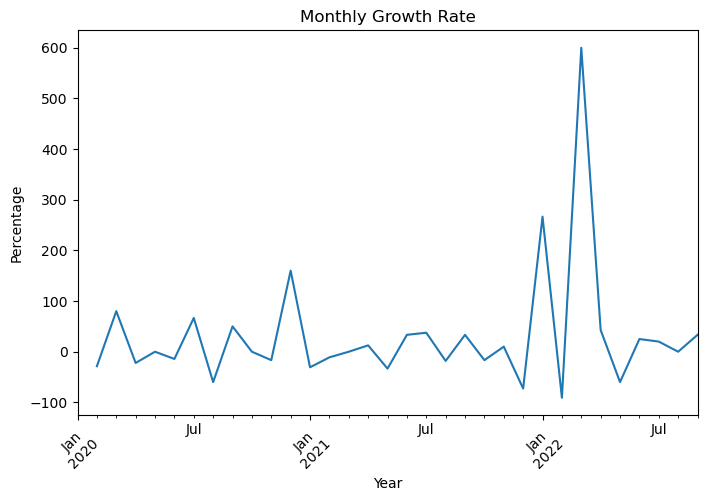

Yearly Growth Rate (%):
date
2021    22.352941
2022   -44.230769
dtype: float64


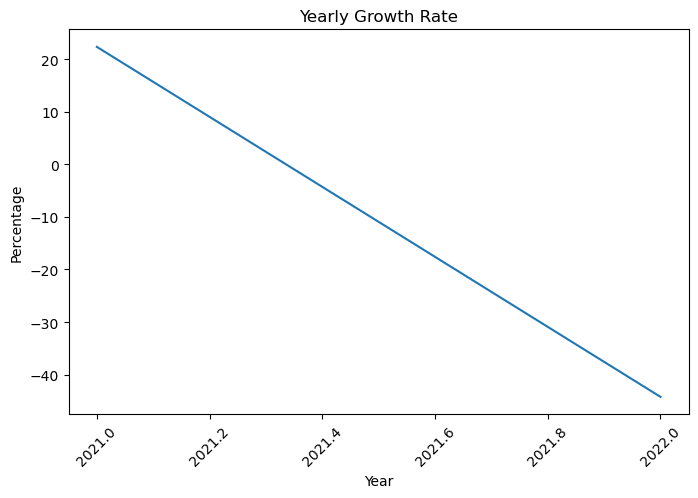

In [8]:
# 4. Monthly and Yearly Growth Rate of Fake News
# Monthly Growth
monthly_fake = df[df["predicted"] == 1].groupby(
    df["date"].dt.to_period("M")
).size()

monthly_growth = monthly_fake.pct_change() * 100

print("Monthly Growth Rate (%):")
print(monthly_growth.dropna())
plt.figure(figsize=(8,5))
monthly_growth.plot(kind="line")
plt.title("Monthly Growth Rate")
plt.ylabel("Percentage")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.show()
# Yearly Growth
yearly_fake = df[df["predicted"] == 1].groupby(
    df["date"].dt.year
).size()

yearly_growth = yearly_fake.pct_change() * 100

print("Yearly Growth Rate (%):")
print(yearly_growth.dropna())
plt.figure(figsize=(8,5))
yearly_growth.plot(kind="line")
plt.title("Yearly Growth Rate")
plt.ylabel("Percentage")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.show()

In [9]:
# 5. Which Keywords Are Strongly Associated with Real News?
feature_names = tfidf.get_feature_names_out()
coefficients = model.coef_[0]

coef_df = pd.DataFrame({
    "word": feature_names,
    "importance": coefficients
})

# Negative values → Real News
real_keywords = coef_df.sort_values(by="importance").head(20)

print("Top Keywords Associated with Real News:")
print(real_keywords)

Top Keywords Associated with Real News:
             word  importance
24            new   -1.703270
32       released   -1.411432
25       official   -1.411432
41      statement   -1.411432
26         passes   -1.216278
31         reform   -1.216278
10      education   -1.216278
17      increases   -1.156042
14         growth   -1.156042
30        quarter   -1.156042
9        economic   -1.156042
7          debate   -1.153010
6       continues   -1.153010
15     healthcare   -1.153010
38         senate   -1.153010
42         summit   -1.040725
21        leaders   -1.040725
4         climate   -1.040725
23           meet   -1.040725
19  international   -1.040725


In [10]:
# 6. Which Keywords Are Strongly Associated with Fake News?
fake_keywords = coef_df.sort_values(by="importance", ascending=False).head(20)

print("Top Keywords Associated with Fake News:")
print(fake_keywords)

Top Keywords Associated with Fake News:
         word  importance
39   shocking    1.827675
44      truth    1.633738
8     details    1.575487
18     inside    1.575487
3    breaking    1.458246
11  exclusive    1.435551
22    massive    1.153194
36    scandal    1.153194
35      rocks    1.153194
29   politics    1.153194
0      agenda    1.126238
34   revealed    1.126238
16     hidden    1.126238
12    exposed    1.119101
27       plan    1.119101
37     secret    1.119101
33     report    1.060844
45        won    1.060844
2     believe    1.060844
1     amazing    0.828713


In [11]:
# 7. Which Source Is Predicted Most Fake?
fake_source = df[df["predicted"] == 1]["source"].value_counts()
print(fake_source)

source
Unknown Blog    247
Name: count, dtype: int64


In [12]:
# 8. Are International News Articles More Likely to Be Fake?
international_keywords = ["international", "global", "world"]

df["international"] = df["title"].str.contains('|'.join(international_keywords), case=False)

international_ratio = df.groupby("international")["predicted"].mean()

print(international_ratio)

international
False    0.553812
True     0.000000
Name: predicted, dtype: float64


Fake News Percentage by Category:
subject
tech        0.549451
world       0.510638
health      0.495935
politics    0.478723
economy     0.438776
Name: predicted, dtype: float64


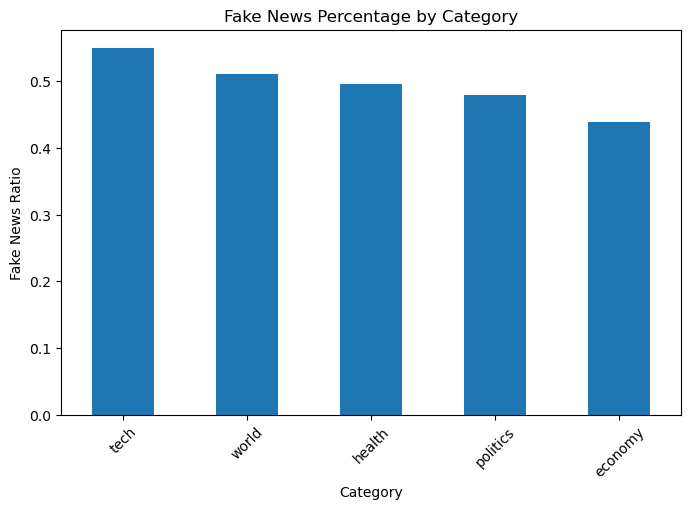

In [13]:
# 9. Which Topic/Category Has the Highest Percentage of Fake News?
category_fake_ratio = df.groupby("subject")["predicted"].mean().sort_values(ascending=False)

print("Fake News Percentage by Category:")
print(category_fake_ratio)

plt.figure(figsize=(8,5))
category_fake_ratio.plot(kind="bar")
plt.title("Fake News Percentage by Category")
plt.ylabel("Fake News Ratio")
plt.xlabel("Category")
plt.xticks(rotation=45)
plt.show()

Average Article Length (Word Count):
predicted
0    15.047431
1    11.574899
Name: article_length, dtype: float64


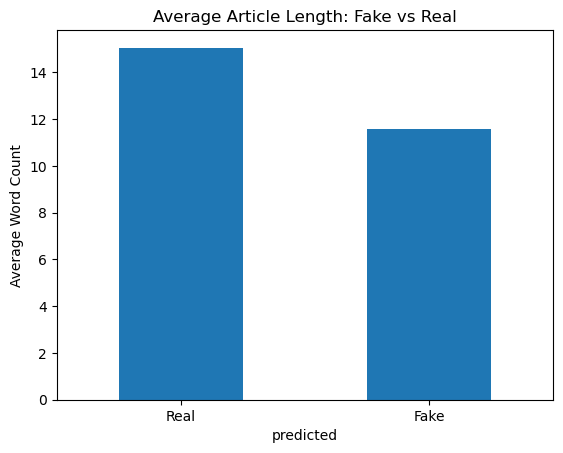

In [14]:
# 10. Does the length of a news article influence whether it is predicted as Fake or Real?
df["article_length"] = df["content"].apply(lambda x: len(str(x).split()))

length_comparison = df.groupby("predicted")["article_length"].mean()

print("Average Article Length (Word Count):")
print(length_comparison)

length_comparison.plot(kind="bar")
plt.title("Average Article Length: Fake vs Real")
plt.ylabel("Average Word Count")
plt.xticks([0,1], ["Real", "Fake"], rotation=0)
plt.show()

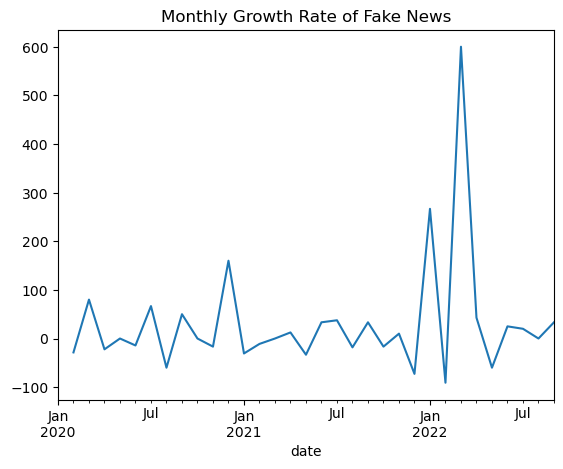

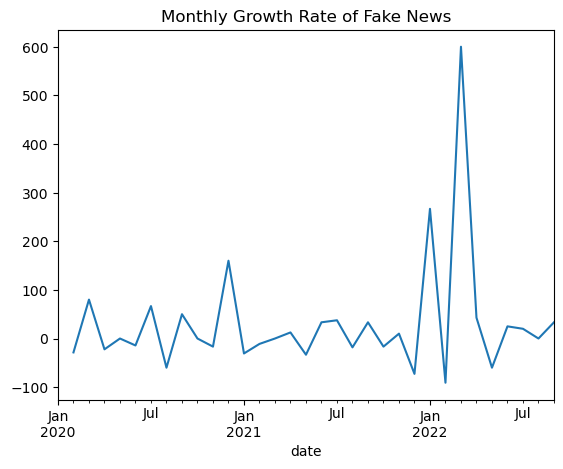

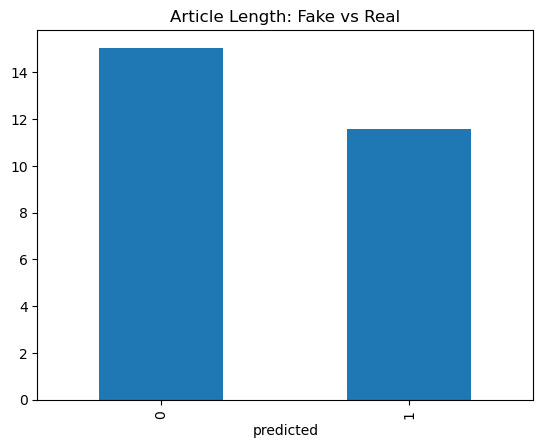

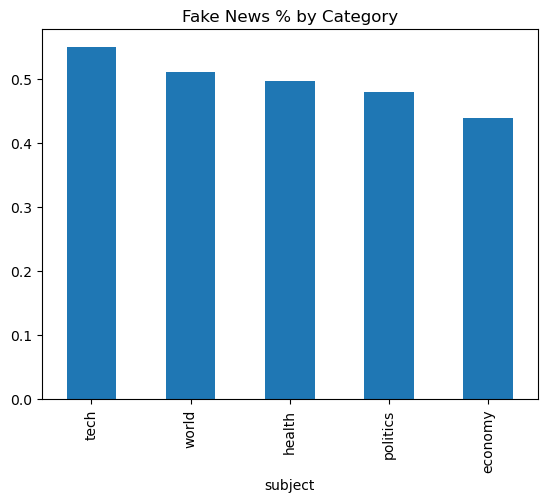

In [5]:
import tkinter as tk
from tkinter import ttk, messagebox

class FakeNewsGUI:

    def __init__(self, root):
        self.root = root
        self.root.title("Fake News Detection & Analysis System")
        self.root.geometry("1150x750")
        self.root.configure(bg="#eef2f7")
        self.root.resizable(False, False)

        title = tk.Label(root,
                         text="Fake News Detection & Analytical Dashboard",
                         font=("Segoe UI", 22, "bold"),
                         bg="#1f3b4d", fg="white", pady=15)
        title.pack(fill="x")

        # Buttons Frame
        btn_frame = tk.Frame(root, bg="#eef2f7")
        btn_frame.pack(pady=15)

        buttons = [
            ("Common Fake Words", self.q1),
            ("Sensational Words", self.q2),
            ("Avg News Per Day", self.q3),
            ("Growth Rate", self.q4),
            ("Real Keywords", self.q5),
            ("Fake Keywords", self.q6),
            ("Most Fake Source", self.q7),
            ("International Analysis", self.q8),
            ("Category Fake %", self.q9),
            ("Article Length", self.q10),
        ]

        row = 0
        col = 0
        for text, cmd in buttons:
            ttk.Button(btn_frame, text=text, command=cmd, width=25)\
                .grid(row=row, column=col, padx=8, pady=8)
            col += 1
            if col == 3:
                col = 0
                row += 1

        # Output Box
        self.output = tk.Text(root, height=18, width=135, font=("Consolas", 10))
        self.output.pack(pady=20)

        # Train Model Automatically
        self.train_model()

    # ================= TRAIN MODEL ================= #
    def train_model(self):
        self.df = pd.read_csv("fake_real_news.csv")
        self.df["date"] = pd.to_datetime(self.df["date"])
        self.df["content"] = self.df["title"] + " " + self.df["text"]

        X = self.df["content"]
        y = self.df["label"]

        self.tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
        X_tfidf = self.tfidf.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(
            X_tfidf, y, test_size=0.2, random_state=42
        )

        self.model = LogisticRegression()
        self.model.fit(X_train, y_train)

        y_pred = self.model.predict(X_test)

        self.df["predicted"] = self.model.predict(
            self.tfidf.transform(self.df["content"])
        )

        self.output.insert(tk.END,
            f"Model Loaded Successfully\nAccuracy: {accuracy_score(y_test, y_pred):.4f}\nF1 Score: {f1_score(y_test, y_pred):.4f}\n\n")

        # ================= QUESTIONS ================= #
    def q1(self):
        fake_titles = self.df[self.df["predicted"] == 1]["title"]
        vectorizer = CountVectorizer(stop_words='english', max_features=20)
        vectorizer.fit(fake_titles)
        words = vectorizer.get_feature_names_out()

        self.output.delete("1.0", tk.END)
        self.output.insert(tk.END, "Most Common Words in Fake Headlines:\n\n")
        self.output.insert(tk.END, "\n".join(words))
                                             
    def q2(self):
        sensational_words = ["shocking", "breaking", "exclusive", "amazing"]
        self.output.delete("1.0", tk.END)

        for word in sensational_words:
            fake_usage = self.df[self.df["predicted"] == 1]["title"]\
                .str.contains(word, case=False).mean() * 100
            real_usage = self.df[self.df["predicted"] == 0]["title"]\
                .str.contains(word, case=False).mean() * 100

            self.output.insert(tk.END,
                f"{word}\nFake: {fake_usage:.2f}%\nReal: {real_usage:.2f}%\n\n")

    def q3(self):
        daily_news = self.df.groupby(self.df["date"].dt.date).size()
        self.output.delete("1.0", tk.END)
        self.output.insert(tk.END,
            f"Average News Per Day: {daily_news.mean():.2f}")

    def q4(self):
        monthly_fake = self.df[self.df["predicted"] == 1]\
            .groupby(self.df["date"].dt.to_period("M")).size()
        monthly_growth = monthly_fake.pct_change() * 100

        self.output.delete("1.0", tk.END)
        self.output.insert(tk.END, "Monthly Growth Rate (%):\n\n")
        self.output.insert(tk.END, monthly_growth.dropna().to_string())

        monthly_growth.plot(kind="line")
        plt.title("Monthly Growth Rate of Fake News")
        plt.show()

    def q5(self):
        coef = self.model.coef_[0]
        words = self.tfidf.get_feature_names_out()
        coef_df = pd.DataFrame({"word": words, "importance": coef})
        real = coef_df.sort_values("importance").head(20)

        self.output.delete("1.0", tk.END)
        self.output.insert(tk.END, real.to_string(index=False))

    def q6(self):
        coef = self.model.coef_[0]
        words = self.tfidf.get_feature_names_out()
        coef_df = pd.DataFrame({"word": words, "importance": coef})
        fake = coef_df.sort_values("importance", ascending=False).head(20)

        self.output.delete("1.0", tk.END)
        self.output.insert(tk.END, fake.to_string(index=False))

    def q7(self):
        fake_source = self.df[self.df["predicted"] == 1]["source"].value_counts()
        self.output.delete("1.0", tk.END)
        self.output.insert(tk.END, fake_source.to_string())

    def q8(self):
        keywords = ["international", "global", "world"]
        self.df["international"] = self.df["title"]\
            .str.contains('|'.join(keywords), case=False)
        ratio = self.df.groupby("international")["predicted"].mean()

        self.output.delete("1.0", tk.END)
        self.output.insert(tk.END, ratio.to_string())

    def q9(self):
        category = self.df.groupby("subject")["predicted"]\
            .mean().sort_values(ascending=False)

        self.output.delete("1.0", tk.END)
        self.output.insert(tk.END, category.to_string())

        category.plot(kind="bar")
        plt.title("Fake News % by Category")
        plt.show()

    def q10(self):
        self.df["article_length"] = self.df["content"]\
            .apply(lambda x: len(str(x).split()))
        length = self.df.groupby("predicted")["article_length"].mean()

        self.output.delete("1.0", tk.END)
        self.output.insert(tk.END, length.to_string())

        length.plot(kind="bar")
        plt.title("Article Length: Fake vs Real")
        plt.show()

# ================= RUN APP ================= #
if __name__ == "__main__":
    root = tk.Tk()
    app = FakeNewsGUI(root)
    root.mainloop()